In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [4]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-11-03,0.3990,0.3843,0.3857,8.735430e+07,34366580.85,0.3894
2022-11-04,0.4263,0.3881,0.3894,2.075810e+08,85203690.74,0.4216
2022-11-05,0.4376,0.4202,0.4216,1.259562e+08,53916199.35,0.4265
2022-11-06,0.4310,0.4017,0.4265,9.715918e+07,40806461.37,0.4021
2022-11-07,0.4161,0.3977,0.4021,9.068004e+07,36890599.24,0.4153


In [5]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-02-11 to 2022-11-07
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   high        1001 non-null   float64
 1   low         1001 non-null   float64
 2   open        1001 non-null   float64
 3   volumefrom  1001 non-null   float64
 4   volumeto    1001 non-null   float64
 5   close       1001 non-null   float64
dtypes: float64(6)
memory usage: 54.7 KB


In [6]:
hist.describe()

,high,low,open,volumefrom,volumeto,close
count,1001.000000,1001.000000,1001.000000,1.001000e+03,1.001000e+03,1001.000000
mean,0.828484,0.756462,0.794172,8.029044e+07,7.166717e+07,0.794525
std,0.744840,0.680718,0.714855,7.622003e+07,9.802997e+07,0.714577
min,0.026530,0.016080,0.023190,1.462457e+06,6.845112e+04,0.023190
25%,0.130200,0.120600,0.124700,2.658166e+07,4.656513e+06,0.125300
50%,0.538800,0.496000,0.515200,6.089323e+07,4.357546e+07,0.515200
75%,1.319000,1.202000,1.263000,1.058774e+08,8.975104e+07,1.263000
max,3.097000,2.906000,2.968000,5.399163e+08,1.095577e+09,2.968000


In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
train, test = train_test_split(hist, test_size=0.2)

In [9]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

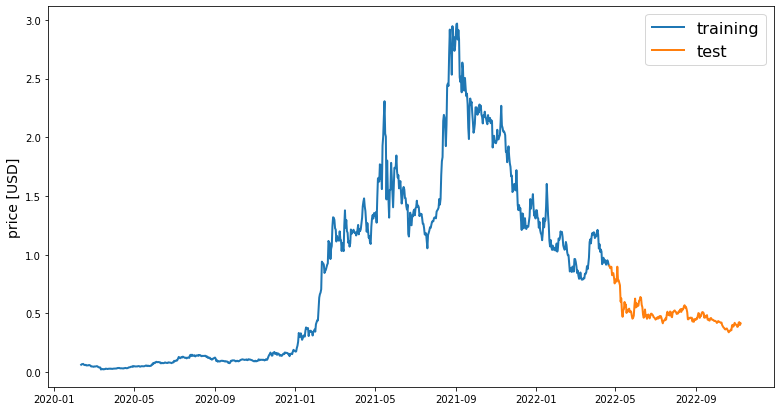

In [10]:
#@title
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [11]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [12]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [13]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [14]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [15]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [16]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [17]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
25/25 [==============================] - 2s 24ms/step - loss: 0.0207 - val_loss: 0.0067
Epoch 2/20
25/25 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 3/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 4/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 5/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 8/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 9/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 10/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 11/20
25/25 

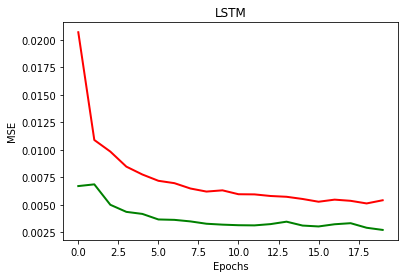

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

7/7 [==============================] - 1s 3ms/step


0.036913721880100114

In [20]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.002730747486922689

In [21]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7147366958377357

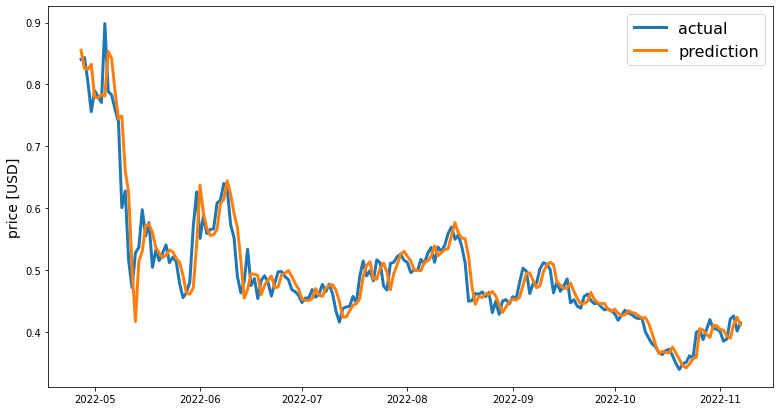

In [22]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)